In [267]:
import sys
import os

import functions
from functions import*
import matplotlib.colors as colors


### State Parameters

In [268]:
boson_dim = 80

N = 4
F = 10
shift = 0

cutoff = F+shift+1

#Bases
logical_plus = np.sin((N * np.pi)/(F + 2*N - F % N)) * fock(boson_dim, 0+shift)

for k in range(1, F//N +1):#+ 1):
    logical_plus += np.sin((k*N + N) * np.pi/(F + 2*N - F % N)) * fock(boson_dim, k*N+shift)

logical_plus = logical_plus.unit()

logical_minus = np.sin((N * np.pi)/(F + 2*N - F % N)) * fock(boson_dim, 0+shift)

for k in range(1, F//N +1):#+ 1):
    logical_minus += (-1)**k * np.sin((k*N + N) * np.pi/(F + 2*N - F % N)) * fock(boson_dim, k*N+shift)

logical_minus = logical_minus.unit()

logical0 = (logical_plus + logical_minus).unit()
logical1 = (logical_plus - logical_minus).unit()

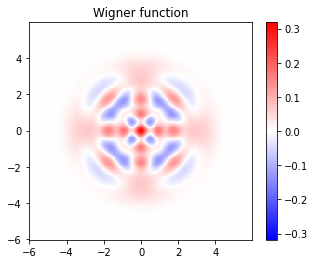

In [269]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)
state = logical_plus

W = wigner(state,xvec,yvec)

norm = colors.CenteredNorm( vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()


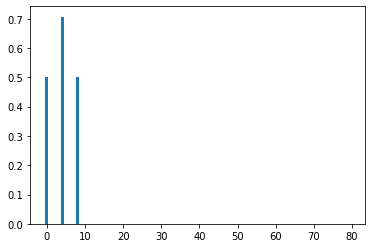

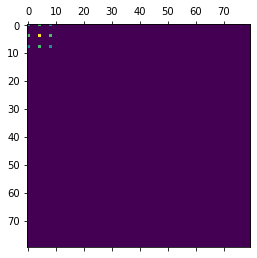

In [231]:

plt.bar(np.arange(0, boson_dim), state.full()[:,0])
plt.show()

dm_state = ket2dm(state)
plt.matshow(np.real(dm_state))

### Stabilisers

In [248]:
#Operators

n_operator = num(boson_dim)
a = destroy(boson_dim)
ln_Z = 1j * 2* np.pi * n_operator / (N)
Z_L = ln_Z.expm()

ancilla_plus = (basis(2, 0) + basis(2, 1)).unit()
ancilla_minus = (basis(2, 0) - basis(2, 1)).unit()

#Ladder operators
phi_operator = fock(boson_dim, 0)*fock(boson_dim, N).dag() #+ fock(boson_dim, 0)*fock(boson_dim, 0).dag()/(10*F)+ fock(boson_dim,boson_dim -1)*fock(boson_dim, boson_dim -1).dag()/(10*F)
for i in range(1, boson_dim-N):
    phi_operator += fock(boson_dim, i) * fock(boson_dim, i+N).dag()

S_l = fock(boson_dim, 0)*fock(boson_dim, N//2).dag()
for i in range(1, boson_dim-N//2):
    S_l += fock(boson_dim, i) * fock(boson_dim, i+N//2).dag()


# S_l = fock(cutoff, 0)*fock(cutoff, N).dag()
# for i in range(1, cutoff-N):
#     S_l += fock(cutoff, i) * fock(cutoff, i+N).dag()

#Just checking
print(logical0.overlap(logical1))
print(expect(n_operator, logical_plus))
print(expect(Z_L, logical_plus))

# print(expect(S_l, logical_plus))

# print(expect( (S_l+S_l.dag())/2, logical_plus))

# print((S_l+S_l.dag())/2)

print(expect(phi_operator + phi_operator.dag(), logical_plus))

#Correction?
coupled_S_l = tensor(ket2dm(ancilla_plus), S_l) + tensor(ket2dm(ancilla_minus), S_l.dag())

coupled_Z = tensor(sigmay(), 0.985*ln_Z).expm()


0j
3.9999999999999996
(0.9999999999999998+0j)
1.4142135623730947


In [249]:
# state = (S_l+S_l.dag()) * state

stab_state = ((phi_operator +phi_operator.dag())/2)* state

print(fidelity(stab_state,stab_state.dag()))

print(stab_state.full()[:,0])

# for i in range(len(stab_state.full()[:,0])):
#     print(stab_state.full()[:,0][i]/state.full()[:,0][i])
# # bar0 = axes[0].bar(np.arange(0, cutoff)-.5, state.diag())
# plt.bar(np.arange(0, boson_dim), stab_state.full()[:,0])

0.42187500426084096
[0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.5       +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.25      +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0. 

In [262]:
def stab_rounds(state, n_rounds, corrector1,corrector2):
    for i in range(n_rounds):
        state = tensor(ket2dm(basis(2, 0)), state)
        psi_new = ( corrector2 * corrector1) * state * (corrector2 * corrector1).dag()
        psi_new = psi_new / psi_new.tr()
        psi_new = psi_new.ptrace(1)
        state = psi_new

    return state

def unconditional_stab(state,corrector3):
        
    state = corrector3 * state * corrector3.dag()
    state = state

    return state

H = 0 * a.dag() * a

# time step
delta_t = 1e-3

psi_logical = logical_plus

psi0 = psi_logical #  fock(boson_dim,0)

psi = ket2dm(psi0)
fidelity_array = [1]
S_l_array = [expect((phi_operator.dag() + phi_operator)/2, psi0).real]
state_stability_array = [0]


for x in range(1, 101):
    times = np.linspace(0.0, delta_t, 200)
    result = mesolve(H, psi, times, [0*np.sqrt(0.001) * a, np.sqrt(18) * a.dag() * a])

    psi = result.states[-1]

    if x % 2 == 0:
        alpha = np.random.normal(0, 0.01) + 1.j * np.random.uniform(0, 0.01)
        D = displace(boson_dim, alpha*0)
        psi = D * psi * D.dag()

    # if x % 1  == 0:
        
    #     psi = stab_rounds(psi, 1, coupled_S_l, tensor(identity(2),identity(boson_dim)))

    if x % 1  == 0:
        
        psi = stab_rounds(psi, 1, coupled_S_l, coupled_Z)   
        
    if x % 7 ==0:
        psi = unconditional_stab(psi,phi_operator)

    S_l_array.append(expect((phi_operator.dag() + phi_operator)/2, psi).real)
    fidelity_array.append(fidelity(psi_logical, psi)**2)


print(S_l_array,)
print(fidelity_array)

[0.7071067811865474, 0.5552526880639234, 0.5227532146523464, 0.45672633351402747, 0.4387029405597697, 0.4005001512767784, 0.39053745110420957, 0.23622897094400308, 0.3240722092775191, 0.3058904906933447, 0.30958310683287504, 0.2978986599339858, 0.3026726114059115, 0.29443442580839757, 0.24507497829614722, 0.26763155169205705, 0.2768147113221542, 0.2703639072830396, 0.2790958835008132, 0.27474986718634276, 0.28281851538774666, 0.1970816727791541, 0.26643919110567216, 0.2622060152687345, 0.272103974235615, 0.26926201276985606, 0.2781162021242906, 0.27581098730076975, 0.2390130122052721, 0.26074297976765426, 0.2708752255871464, 0.26749355429798316, 0.2766130279073291, 0.274246756346435, 0.28237019169305777, 0.20681286896531823, 0.2700309431280408, 0.2668951335460001, 0.2761003085768669, 0.27390864206221593, 0.28208012738670113, 0.2801916119880773, 0.24640808266169245, 0.26688578301521315, 0.2761177976532078, 0.27306993460435686, 0.28137432328988016, 0.2791748297409379, 0.2865786041599119,

(-0.1, 1.1)

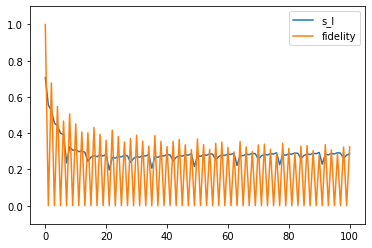

In [263]:
plt.plot(S_l_array,label = 's_l')
plt.plot(fidelity_array,label = 'fidelity')

plt.legend()
plt.ylim([-0.1,1.1])

0.21442187696429896
8.971285450350477
1.0
[[0.13628738+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]]


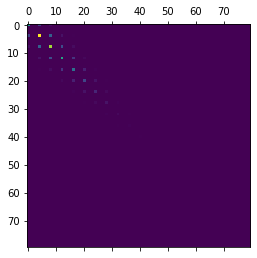

In [266]:
print((psi**2).tr())
print(expect(n_operator, psi))
print((psi).tr())
print(psi.full()[0:20][0:20])

plt.matshow(np.real(psi))

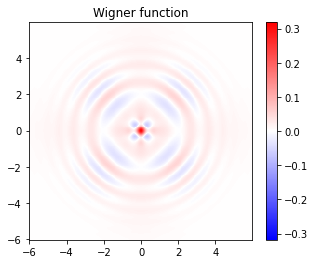

In [265]:

plt.figure(figsize=(5,4))

xvec = np.arange(-6, 6, 10.0 / 200)
yvec = xvec

X, Y = np.meshgrid(xvec, yvec)

diss_state = psi

W = wigner(diss_state,xvec,yvec)

norm = colors.CenteredNorm( vcenter=0)

plt.pcolormesh(X, Y, W, cmap = 'bwr',  norm=norm)
plt.colorbar();
plt.title('Wigner function')
plt.show()

In [12]:


'''psi0 = logical0
psi = ket2dm(psi0)
range_epsilon = np.linspace(-1, 1, 400)
for x in range_epsilon:
    coupled_Z = tensor(sigmay(), x * ln_Z).expm()
    psi = stab_rounds(psi, 1, coupled_S_l, coupled_Z)
    print(x, fidelity(psi, logical0))'''




psi0 = logical0
psi = ket2dm(psi0)
fidelity_array_2 = [1]
S_l_array_2 = [expect(S_l, psi0).real]
time_array = delta_t * np.arange(31)

for x in range(400):
    times = np.linspace(0.0, delta_t, 200)
    result = mesolve(H, psi, times, [np.sqrt(0.001) * a, np.sqrt(0.018) * a.dag() * a])

    psi = result.states[-1]
    #psi = stab_rounds(psi, 1, coupled_S_l, coupled_Z)
    if x % 2 == 0:
        alpha = np.random.normal(0, 0.01) + 1.j * np.random.uniform(0, 0.01)
        D = displace(cutoff, alpha)
        psi = D * psi * D.dag()

    S_l_array_2.append(expect(S_l, psi).real)
    fidelity_array_2.append(fidelity(psi0, psi))

print(S_l_array_2)
print(fidelity_array_2)




TypeError: Incompatible Qobj shapes

In [ ]:
plt.plot(S_l_array_2)
plt.plot(fidelity_array_2)
plt.ylim([-0.1,1,1])
plt.show()
